# Lab 1: Intro to Remote Sensing and EE

**Purpose**: The purpose of this lab is to enable you to search, find and visualize remotely sensed imagery in Google Earth Engine.  At completion, you should be able to understand the difference between radiance and reflectance, load imagery with the units of interest (radiance or reflectance, for example), make true color and false color composites and identify land cover types based on spectral characteristics.

**Prerequisites**: If you are new to Python or programming, go through this guide.  Review the Earth Engine Code Editor doc and the Get Started guide.




**Searching (and finding) Landsat imagery**

Landsat is a NASA program that has launched a sequence of Earth observation satellites, named Landsat 1, 2,... etc.  Note that the Landsat program has resulted in the longest continuous observation of the Earth's surface.  In this exercise, you will load a Landsat scene over your area of interest, inspect the units and make a plot of radiance.   Specifically, use imagery from the Landsat 8, the most recent of the sequence of Landsat satellites.  To inspect a Landsat 8 image (also called a scene) in your region of interest (ROI), define your ROI as a point, filter the image collection to get a scene with few clouds, display some information about the image in the console.

In [37]:
# Initializing display and earthengine
from IPython.display import Image
%matplotlib inline

import ee
ee.Initialize()

a) Let's find San Francisco coordinates using the geopy module

In [38]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="cuahsi",format_string="%s, San Francisco CA")
address, (latitude, longitude) = geolocator.geocode("San Francisco")
print(latitude, longitude)

37.7792808 -122.4192363


b) Use the EarthEngine geometry tools to make a point in San Francisco.  
Name the resultant import 'point'

In [39]:
#defining region of interest using a point from GeoPlanner

#fSan Francisco is 37.76599°N -122.44147°E

point = ee.Geometry.Point([longitude, latitude])

c) Search for 'Landsat 8 Surface Corrected' here: https://developers.google.com/earth-engine/datasets/catalog/ and get the handle name (e.g. ee.ImageCollection("LANDSAT/LC08/C01/T1_SR"). Name the import 'landsat'.


In [40]:
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

d) Filter the ImageCollection by date and location, sort by a image property called 'CLOUD_COVER' and get the first image out of this sorted collection:

All the properties of an satellite is also in the datasets catalog


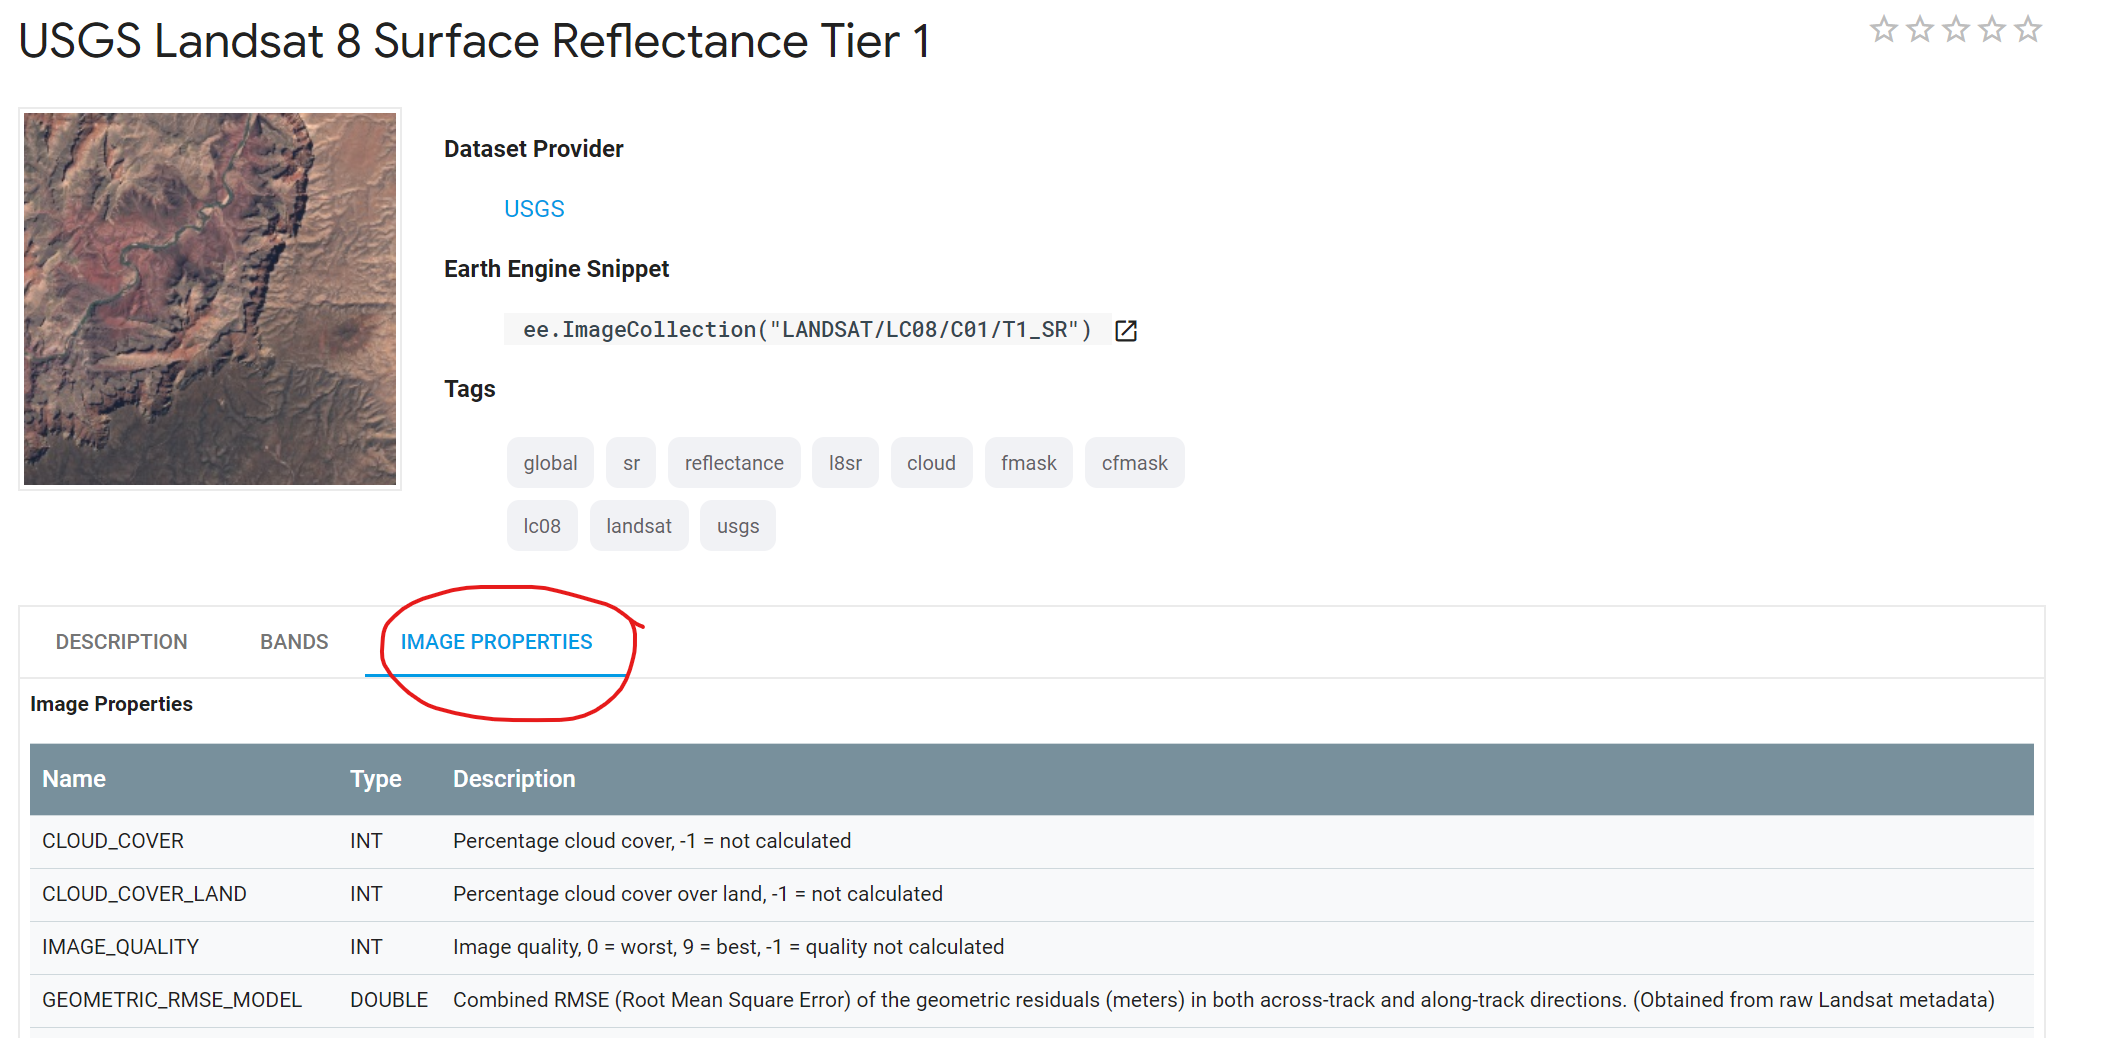

In [41]:
# Note that we need to cast the result of first() to Image.
image = ee.Image(landsat

#    // Filter to get only images in the specified range.
    .filterDate('2019-01-01', '2019-12-31')

#    // Filter to get only images at the location of the point.This can be a polygon too.
    .filterBounds(point)

#    // Sort the collection by a metadata property.
    .sort('CLOUD_COVER')

#    // Get the first image out of this collection.
    .first())

# image.getInfo()

The variable "image" now stores a reference to an object of type ee.Image.  Display the image by printing it to the console:

In [42]:
#// Add the image to the map.
url = image.getThumbURL({'dimensions': 500,'bands': ['B4', 'B3', 'B2'],})
Image(url=url)

The image is grey because we have not told EarthEngine the band layers we want form the satellite and the min and max values to use. Here is how we define these two characteristics:

In [43]:
# Print the image band names to the console.
band_names = image.bandNames()
print(band_names.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']


In Landsat 8 Surface Products these bands are also described in the dataset website:
    

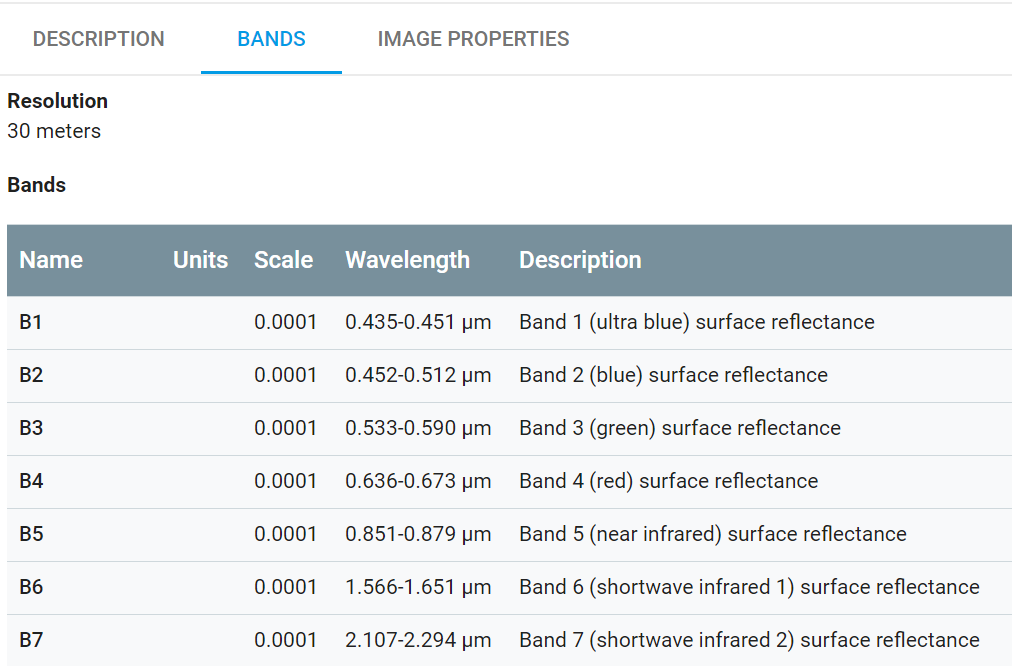

In [44]:
# The image requires the scale = 0.0001 as shown above.
image = image.multiply(0.0001)

In [45]:
#// Define visualization parameters in a dictionary.
# No radiation is represented by zero (min value), and in RGB the average max value is 0.2
trueColor = {
  'dimensions': 500,  
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.2,
}

In [46]:
#// Add the image to the map, using the visualization parameters.
url = image.getThumbURL(trueColor)
Image(url=url)

In [47]:
#// Define false-color visualization parameters.# No radiation is represented by zero (min value), for Infrared the average max value is 0.6

falseColor = {
  'dimensions': 500,
  'bands': ['B5', 'B4', 'B3'],
  'min': 0,
  'max': 0.5
}

In [48]:
#// Add the image to the map, using the visualization parameters.
url = image.getThumbURL(falseColor)
Image(url=url)

### Visualizing Landsat imagery

Recall that Landsat 8 measures radiance in multiple spectral bands.  A common way to visualize images is to set the red band to display in red, the green band to display in green and the blue band to display in blue.  This means trying to match the spectral response of the instrument to the spectral response of the photoreceptors in the human eye.  It's not a perfect match.  Despite that, a visualization done in this manner is called a true-color image.  When the display bands don't match human visual perception, the resultant visualization is called a false-color composite.  In this exercise, you will make several different visualizations of the scene you found in exercise 1.  

Add the image found in exercise 1 to the map display with the following code:


In [49]:
#// Hardcode a point in Golden Gate Park.
ggPark = ee.Geometry.Point([-122.4860, 37.7692])

#// Define reflective bands as bands B1-B7.  
reflectiveBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']


#// See http://landsat.usgs.gov/band_designations_landsat_satellites.php
wavelengths = [0.44, 0.48, 0.56, 0.65, 0.86, 1.61, 2.2];

#// Select only the reflectance bands of interest.
reflectanceImage = image.select(reflectiveBands);

In [50]:
# Sample for values at the point.
scale = 30 # pixel size of image

result = reflectanceImage.reduceRegion(ee.Reducer.first(), ggPark, scale)
value_info = result.getInfo()

In [51]:
import pandas as pd
df =pd.DataFrame(list(value_info.items()),columns=['Band','Reflectance'])
# # sort bands
df.sort_values('Band', inplace=True) 
# # add wavelenth data to frame
df = df.assign(Wavelength=wavelengths)
df

,Band,Reflectance,Wavelength
0,B1,0.0265,0.44
1,B2,0.0291,0.48
2,B3,0.0552,0.56
3,B4,0.0321,0.65
4,B5,0.4265,0.86
5,B6,0.2275,1.61
6,B7,0.1088,2.20


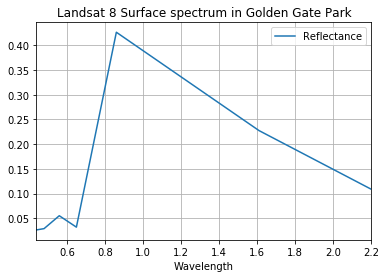

In [52]:
ax =df.plot.line(x='Wavelength', 
             y='Reflectance',
             title= 'Landsat 8 Surface spectrum in Golden Gate Park'
             )
ax.grid()

## Assignment
1. In your code, get the value of a variable called *azimuth* to the solar azimuth of the image being processed.  Do not hardcode the number.  Use *getInfo()*.  Print the result.

2. Create a layer to the map in which the image is displayed with band 7 set to red, band 5 set to green and band 3 set to blue. 

3. What is the brightness temperature of the golden gate park point?  Make a variable in your code called temperature and set it to the band 10 brightness temperature.  Hint:

var temperature = image.reduceRegion({
	<YOUR SOLUTION HERE>
}).get(<YOUR SOLUTION HERE>);

Use this guide for help.https://developers.google.com/earth-engine/reducers_reduce_region